# Problema de regresión usando sci-kitlearn

El siguiente ejemplo presenta las etapas básicas de un proyecto de analítica de datos en una tarea de regresión, orientadas a:

- Preproceso de atributos con campos vacios y tipo texto.
- Entrenamiento y selección de un modelo de regresión bajo una estrategia de validación cruzada.
- La utilización de diccionarios para la sintonización de hiperparámetros.
-Se ilustra también la creación de clases (objetos) propios compatibles con la clase pipeline de sci-kitlearn.

**Base de datos utilizada**: [FIFA 2019 - Kaggle](https://www.kaggle.com/karangadiya/fifa19).

# Lectura de la base de datos con Pandas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Librerias para proceso
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline

%matplotlib inline
csv_path = '../data/data.csv'

Xdata = pd.read_csv(csv_path)

col_drop = ['Unnamed: 0', 'Name','ID','Photo','Flag','Club Logo','Loaned From'] # Variables a descartar (no contienen información relevante)
Xdata.drop(columns = col_drop, inplace = True)
Xdata.head()

,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,International Reputation,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,31,Argentina,94,94,FC Barcelona,€110.5M,€565K,2202,Left,5.0,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,33,Portugal,94,94,Juventus,€77M,€405K,2228,Right,5.0,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,26,Brazil,92,93,Paris Saint-Germain,€118.5M,€290K,2143,Right,5.0,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,27,Spain,91,93,Manchester United,€72M,€260K,1471,Right,4.0,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,27,Belgium,91,92,Manchester City,€102M,€355K,2281,Right,4.0,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


# Identificar tipos de variables, campos perdidos y preproceso básico a realizar

In [3]:
Xdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18207 entries, 0 to 18206
Data columns (total 82 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       18207 non-null  int64  
 1   Nationality               18207 non-null  object 
 2   Overall                   18207 non-null  int64  
 3   Potential                 18207 non-null  int64  
 4   Club                      17966 non-null  object 
 5   Value                     18207 non-null  object 
 6   Wage                      18207 non-null  object 
 7   Special                   18207 non-null  int64  
 8   Preferred Foot            18159 non-null  object 
 9   International Reputation  18159 non-null  float64
 10  Weak Foot                 18159 non-null  float64
 11  Skill Moves               18159 non-null  float64
 12  Work Rate                 18159 non-null  object 
 13  Body Type                 18159 non-null  object 
 14  Real F

## Se presentan atributos tipo int, float y texto, algunos de ellos con datos perdidos.

# Partición en conjunto de training y testing.

**Nota**: En este caso se cuenta con una buena cantidad de datos 18.000 aprox., por lo que se realizará una validación hold-out, con 70% de datos para entrenamiento y 30% para evaluación. Sobre el conjunto de entrenamiento se realizará una validación cruzada de 5 folds (k=5) para determinar el mejor modelo e hiperparámetros.

Se define el atributo Release Clause como salida.

In [4]:
# Partición entrenamiento y evaluación
# Tamaño Xtrain 70%, Tamaño Xtest 30%

Xtrain, Xtest = train_test_split(Xdata,test_size=0.3)
col_sal = "Release Clause"
ytrain = Xtrain[col_sal]
ytest = Xtest[col_sal]
Xtrain.drop(columns=col_sal,inplace=True)
Xtest.drop(columns=col_sal,inplace=True)


**Nota**: Recuerde que puede usar la partición estratificada para preservar la distribución de la salida de interés en los folds

# Preproceso: completar datos y codificar datos tipo texto


In [5]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="most_frequent") # Se utiliza estimador de moda
ytrain = imputer.fit_transform(pd.DataFrame(ytrain)).reshape(-1) # Ajuste sobre la salida
ytest = imputer.transform(pd.DataFrame(ytest)).reshape(-1) # Evaluar sobre datos de test

print(ytrain.shape, ytest.shape)

(12744,) (5463,)


**Nota**: Dado que la variable de salida esta en formato moneda se debe codificar meidante función particular (custom). También, se creará una función para codificar las variables tipo evolución características del jugador.

---



In [6]:
ytrain[0]

'€50K'

In [7]:
# Codificar variables moneda
def code_euro(y):
    yc = np.zeros(y.shape[0])
    for i in range(y.shape[0]):
        if y[i][-1]=='M': yc[i] = float(y[i][1:-1])*10**6   # Buscar M y reemplazar 10^6
        elif y[i][-1]=='K': yc[i] = float(y[i][1:-1])*10**3 # Buscar K y reemplazar por 10^3
        else: yc[i] = float(y[i][1:])
    return yc

# Codificar estadísticas
def code_stats(y):
    yc = np.zeros(y.shape[0])
    for i in range(y.shape[0]):
        if y.iloc[i].find("+") > -1: # Encontrar signo + en str y casteo a flotante
            yc[i] = float(y.iloc[i][:y.iloc[i].find("+")])+float(y.iloc[i][y.iloc[i].find("+")+1:])
        else: yc[i] = float(y.iloc[i])
    return yc

In [8]:
# Codificar salida
ytrain_num = code_euro(ytrain)
ytest_num = code_euro(ytest)

In [9]:
ytrain_num[:5]

array([  50000., 1300000., 1100000.,  500000., 1100000.])

## Se definen las variables para codificar utilizando las funciones establecidas de moneda, estadísticas y las tipo texto con OrdinalEncoder y OneHotEncoder.

In [10]:
# Definir columnas tipo string  para codificar moneda, estadistica fifa y categoricas
col_euro = ['Value','Wage'] # Variables tipo moneda
col_stats = ['LS','ST','RS','LW','LF','CF','RF','RW','LAM',
             'CAM','RAM','LM','LCM','CM','RCM','RM','LWB',
             'LDM','CDM','RDM','RWB','LB','LCB','CB','RCB','RB'] # Variables tipo mejora jugadores

cat = ['Nationality','Club','Body Type','Position','Preferred Foot',
        'Work Rate','Real Face','Contract Valid Until'] # Variables a codificar OrdinalEncoder y OneHotEncoder
items = []
for i in cat:
    items += [list(Xdata[i].value_counts().index)]
cat_usr = dict(zip(cat, items)) # Se crean diccionarios con las variables y sus posibles valores

In [11]:
Xdata['Nationality'].value_counts()

,count
Nationality,
England,1662
Germany,1198
Spain,1072
Argentina,937
France,914
...,...
New Caledonia,1
Fiji,1
São Tomé & Príncipe,1


In [12]:
cat_usr.keys()

dict_keys(['Nationality', 'Club', 'Body Type', 'Position', 'Preferred Foot', 'Work Rate', 'Real Face', 'Contract Valid Until'])

In [13]:
cat_usr['Body Type']

['Normal',
 'Lean',
 'Stocky',
 'Messi',
 'C. Ronaldo',
 'Neymar',
 'Courtois',
 'PLAYER_BODY_TYPE_25',
 'Shaqiri',
 'Akinfenwa']

# Se crea clase propia (custom) para ejecutar el preproceso que sea compatible con scikitlearn

In [14]:
# Transformer custom
from sklearn.base import BaseEstimator, TransformerMixin # Objetos básicos para herencia de clase

class mypre_fifa(BaseEstimator,TransformerMixin):
    # Inicializacion de clase y varaibles
    def __init__(self, col_euro,col_stats, cat_usr): # Constructor clase
        self.col_euro = col_euro # Lista atributos tipo moneda
        self.col_stats = col_stats # Lista atributos tipo estadistica
        self.cat_usr = cat_usr # Lista de atributos categoricos

    def fit(self,X, *_): # Función de ajuste -> *_ para indicar que puede recibir más entradas en el pipeline
        Xi = X.copy() # Copiar dataset para no reemplazar original
        self.imputer_num = SimpleImputer(strategy="most_frequent") # Crear imputador tipo moda
        self.a = Xi.columns[np.sum(Xi.isna())> 0] # Encontrar columnas con datos faltantes
        self.imputer_num.fit(Xi[self.a]) # Ajustar imputador
        Xi[self.a] = self.imputer_num.transform(Xi[self.a]) # Evaluar datos con el imputador

        for i in self.col_euro: # Codificar tipo moneda
            Xi[i] = code_euro(np.array(Xi[i]))

        for i in self.col_stats: # Codificar datos estadisticos
            Xi[i] = code_stats(Xi[i])

        # height, wieght corregir formato
        Xi['Height'].replace(regex=["'"], value='.',inplace=True) # Reemplaza unidad ' con .
        for i in Xi.index:
            Xi.loc[i,'Weight'] = float(Xi.loc[i,'Weight'][:-3]) # Elimnar unidades
            Xi.loc[i,'Height'] = float(Xi.loc[i,'Height']) # Eliminar unidades

        Xi['Height'] = Xi['Height'].astype('float64')
        Xi['Weight'] = Xi['Weight'].astype('float64') # Asegurar formato flotante

        Xi['Joined'] = Xi['Joined'].replace(regex="/",value="") # Codificar fecha
        Xi['Joined'] = Xi['Joined'].astype('float64')

        cat = [] #Codificar variables categoricas con ordinal encoder
        for i in self.cat_usr.keys():
            cat = cat + [[*self.cat_usr.get(i)]]
        self.col_cat_usr = OrdinalEncoder(categories=cat) # OneHotEncoder(categories=cat,sparse=False)
        Xi[[*self.cat_usr.keys()]] =self.col_cat_usr.fit_transform(Xi[[*self.cat_usr.keys()]])
        # Si utilizar OneHotEncoder debe concatenar las columnas resultantes

        return self

    def transform(self, X, *_): # Función transformador -> pensando en datos nuevos
        Xi = X.copy()
        Xi[self.a] = self.imputer_num.transform(Xi[self.a])

        for i in self.col_euro:
            Xi[i] = code_euro(np.array(Xi[i]))
        for i in self.col_stats:
            Xi[i] = code_stats(Xi[i])

                #height, wieght
        Xi['Height'].replace(regex=["'"], value='.',inplace=True)
        for i in Xi.index:
            Xi.loc[i,'Weight'] = float(Xi.loc[i,'Weight'][:-3])
            Xi.loc[i,'Height'] = float(Xi.loc[i,'Height'])

        Xi['Height'] = Xi['Height'].astype('float64')
        Xi['Weight'] = Xi['Weight'].astype('float64')

        Xi['Joined'] = Xi['Joined'].replace(regex="/",value="")
        Xi['Joined'] = Xi['Joined'].astype('float64')

        Xi[[*self.cat_usr.keys()]] =self.col_cat_usr.transform(Xi[[*self.cat_usr.keys()]])
        return Xi

    def fit_transform(self,X,*_): # Ajustar y transformar en cascada
        self.fit(X)
        return self.transform(X)

In [15]:
mypre = mypre_fifa(col_euro=col_euro,col_stats=col_stats,cat_usr = cat_usr)
Xtrain_pre = mypre.fit_transform(Xtrain)

**Nota**: Recuerde que ninguna etapa del proceso puede utilizar los datos de test para sintonizar parámetros.

In [16]:
Xtest_pre = mypre.transform(Xtest) #No se puede fit solo transform-> parámetros ajustados sobre Xtrain

In [17]:
Xtrain_pre.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12744 entries, 17855 to 8826
Data columns (total 81 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       12744 non-null  int64  
 1   Nationality               12744 non-null  float64
 2   Overall                   12744 non-null  int64  
 3   Potential                 12744 non-null  int64  
 4   Club                      12744 non-null  float64
 5   Value                     12744 non-null  float64
 6   Wage                      12744 non-null  float64
 7   Special                   12744 non-null  int64  
 8   Preferred Foot            12744 non-null  float64
 9   International Reputation  12744 non-null  object 
 10  Weak Foot                 12744 non-null  object 
 11  Skill Moves               12744 non-null  object 
 12  Work Rate                 12744 non-null  float64
 13  Body Type                 12744 non-null  float64
 14  Real Fac

Las variables fueron codificadas $X_{train}\in\mathbb{R}^{N \times P}$

# Se realiza análisis exploratorio básico

In [18]:
corr_matrix = Xtrain_pre.corr() # Matriz de correlación
corr_matrix.style.background_gradient(cmap='coolwarm')

Sobre los datos preprocesados de entrenamiento, se presenta las gráficas de histograma, dispersión (scatter matrix) y diagramas de caja para la salida y al menos tres atirbutos de entrada, teniendo en cuenta:
* Datos preprocesados.
* Datos preprocesados más StandardScaler
* Datos preprocesados más MinMaxScaler.

In [19]:
Xtrain_pre.columns # Atributos disponibles

Index(['Age', 'Nationality', 'Overall', 'Potential', 'Club', 'Value', 'Wage',
       'Special', 'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', 'Position',
       'Jersey Number', 'Joined', 'Contract Valid Until', 'Height', 'Weight',
       'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM',
       'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB',
       'LCB', 'CB', 'RCB', 'RB', 'Crossing', 'Finishing', 'HeadingAccuracy',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility',
       'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength',
       'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision',
       'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle',
       'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes'],
 

In [20]:
Xm =pd.DataFrame(Xtrain_pre[['Age','Overall','Potential']],columns=['Age','Overall','Potential']) # Definir pandas con atributos seleccionados
Xm['Output'] = ytrain_num # Agregar salida

Xtrain_pre2 = Xtrain_pre.copy()
Xtrain_pre2['output'] = ytrain_num
corr_matrix2 = Xtrain_pre2.corr() # Matriz de correlación
corr_matrix2.style.background_gradient(cmap='coolwarm')

In [21]:
abs(corr_matrix2["output"]).sort_values(ascending=False)

,output
output,1.000000
Value,0.973971
Wage,0.832313
International Reputation,0.619162
Overall,0.587730
...,...
GKDiving,0.024170
GKPositioning,0.023930
Preferred Foot,0.015698
Height,0.010610


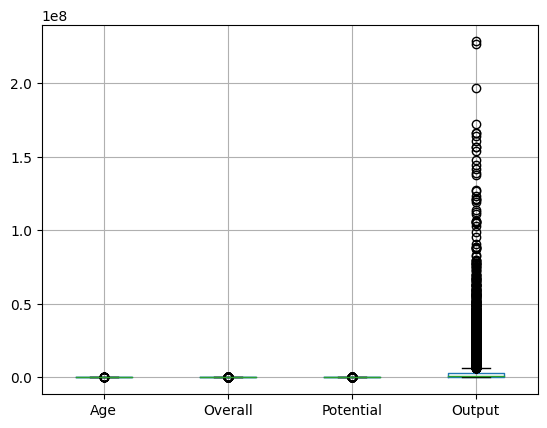

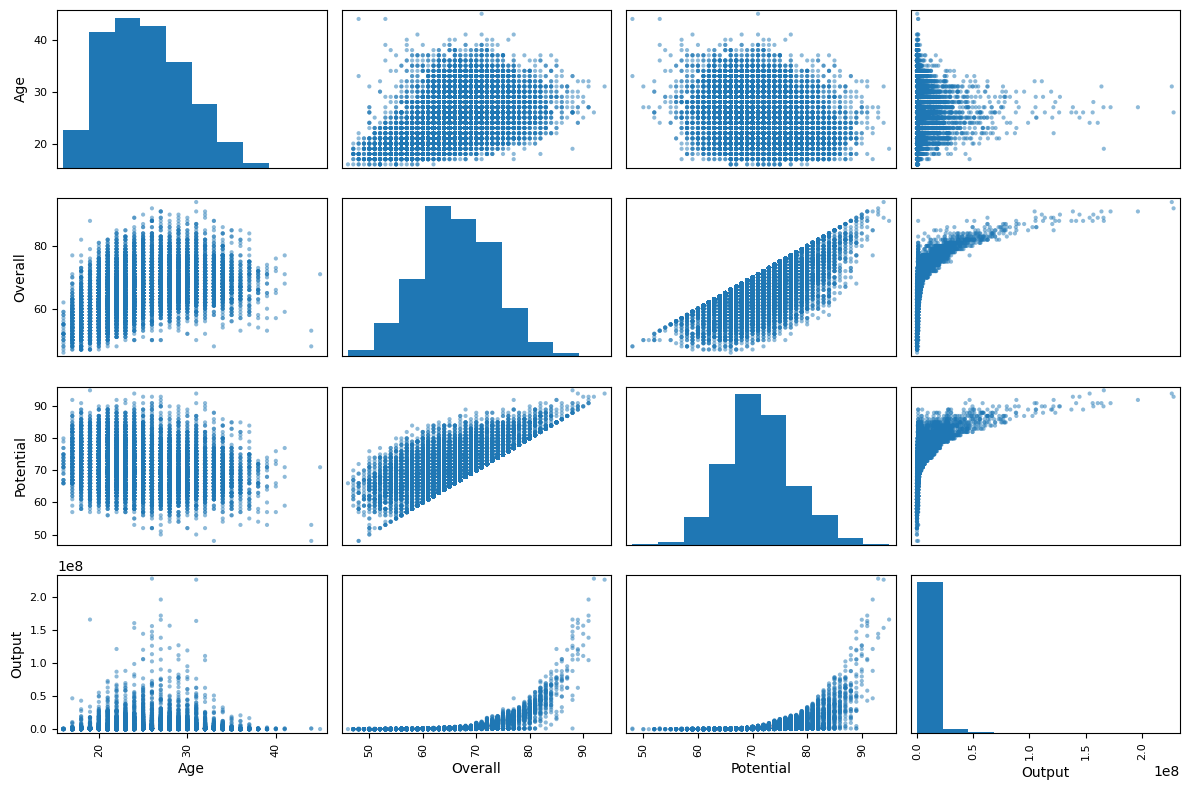

In [22]:
from pandas.plotting import scatter_matrix

Xm.boxplot() # Grafica de caja
plt.show()
scatter_matrix(Xm, figsize=(12, 8)) # Scatter con histogramas
plt.tight_layout()
plt.show()

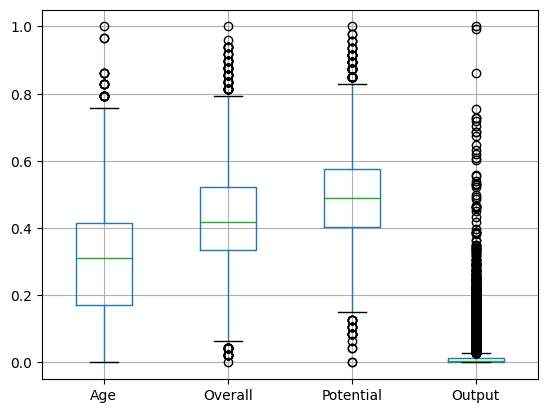

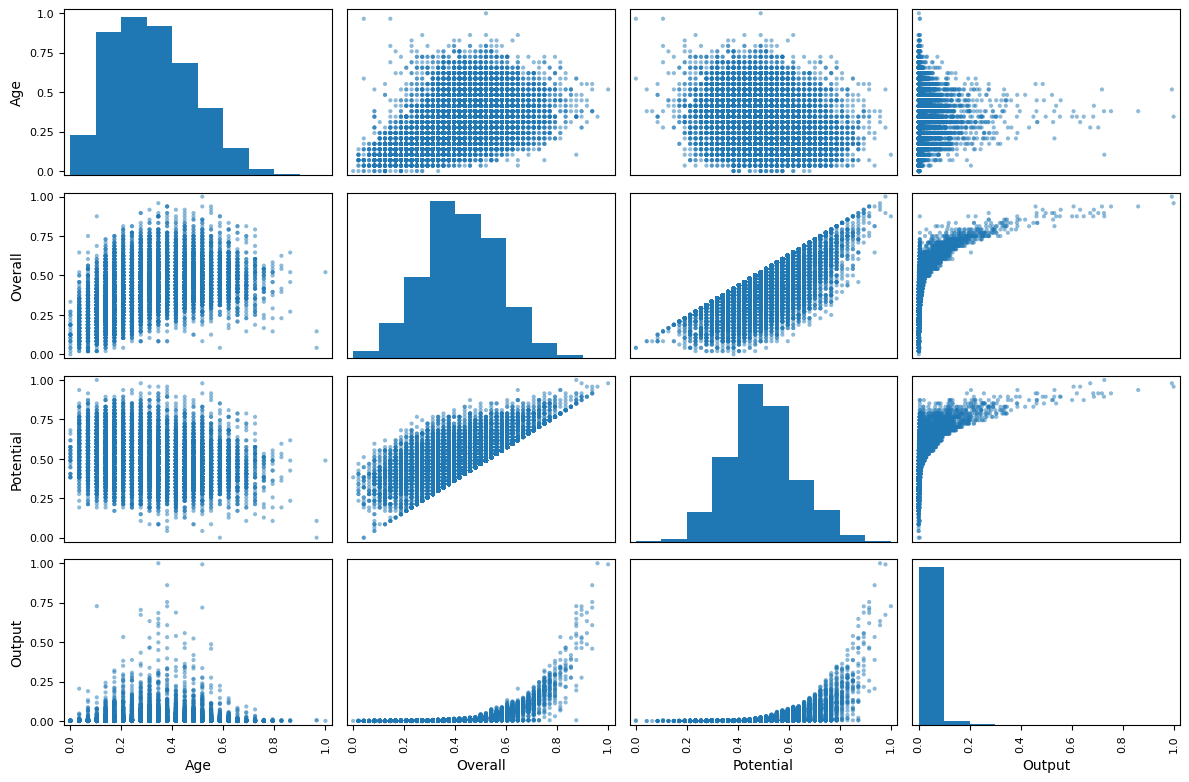

In [23]:
from sklearn.preprocessing import MinMaxScaler
#scaler = StandardScaler()
scaler = MinMaxScaler()

Xm_pre_sca = pd.DataFrame(scaler.fit_transform(Xm),columns=Xm.columns)
Xm_pre_sca.boxplot() # Grafica de caja
plt.show()
scatter_matrix(Xm_pre_sca, figsize=(12, 8)) # Scatter con histogramas
plt.tight_layout()
plt.show()


# Se define pipeline para entrenar un modelo de regresión

**Nota:** Se sugiere utilizar un preproceso de normalización tipo StandardScaler o MinMaxScaler para evitar problemas de escala a la hora de identificar los patrones de interés.


A continuación se genera pipeline completo inlcuyendo preproceso custom, standardscaler y modelo de regresión lineal por mínimos cuadrados.

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
steps = [('preproceso',mypre_fifa(col_euro=col_euro,col_stats=col_stats,cat_usr = cat_usr)),
         ('scaler', StandardScaler()),
         ('regresion',LinearRegression())
         ]
metodo_full = Pipeline(steps=steps)
metodo_full.fit(Xtrain,ytrain_num) # Entrena todos los pasos

Pipeline(steps=[('preproceso',
                 mypre_fifa(cat_usr={'Body Type': ['Normal', 'Lean', 'Stocky',
                                                   'Messi', 'C. Ronaldo',
                                                   'Neymar', 'Courtois',
                                                   'PLAYER_BODY_TYPE_25',
                                                   'Shaqiri', 'Akinfenwa'],
                                     'Club': ['FC Barcelona', 'Valencia CF',
                                              'Fortuna Düsseldorf',
                                              'Cardiff City', 'Rayo Vallecano',
                                              'CD Leganés', 'Frosinone',
                                              'Newcastle United', 'Southampton',
                                              'Burnley', 'Eintracht Frankfurt',
                                              'Wolve...
                                     'Work Rate': ['Medium/ Medium',
                                                   'High/ Medium',
                                                   'Medium/ High', 'High/ High',
                                                   'Medium/ Low', 'High/ Low',
                                                   'Low/ Medium', 'Low/ High',
                                                   'Low/ Low']},
                            col_euro=['Value', 'Wage'],
                            col_stats=['LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF',
                                       'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM',
                                       'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM',
                                       'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB',
                                       'RB'])),
                ('scaler', StandardScaler()),
                ('regresion', LinearRegression())])

In [25]:
ytest_e = metodo_full.predict(Xtest) # Se evalua el desempeño en el conjunto de test


Se grafican salida original y las predicciones

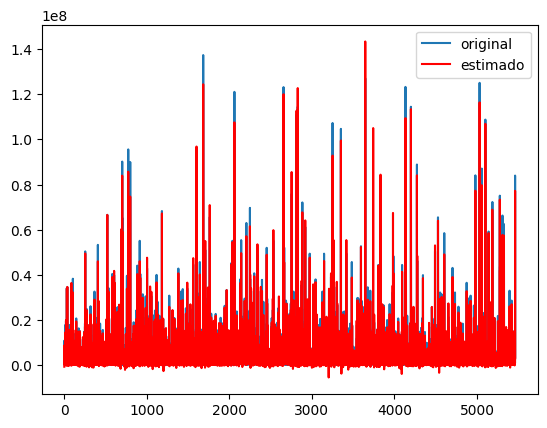

In [26]:
plt.plot(ytest_num,label='original')
plt.plot(ytest_e,'r',label='estimado')

plt.legend()
plt.show()

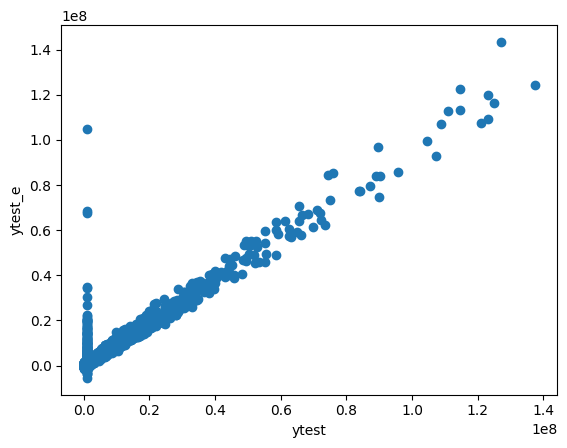

In [27]:
plt.scatter(ytest_num,ytest_e)
plt.xlabel('ytest')
plt.ylabel('ytest_e')
plt.show()